In [1]:
# Biblioteca de importação
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()
sns.set(rc={'figure.figsize':(15,6)})
%matplotlib inline
from sympy.plotting import plot
from sympy import *
#from math import exp
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
#from numpy import log
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.arima_model import ARMAResults
from sklearn.metrics import mean_squared_error
import pmdarima as pm
import warnings


In [2]:
# Verifica a pasta corrente
pasta = os.getcwd()

In [3]:
pasta_resultados = os.path.join(pasta, "resultados")

In [4]:
# index_col para não importar Unnamed column.
df_dados = pd.read_csv(pasta_resultados + '/' + 'df_dados.csv', index_col=[0]) 

In [5]:
#pd.set_option("display.precision", 5)
# pd.set_option('display.float_format', lambda x: '%.5f' % x)
#pd.reset_option('display.float_format')
# Exibir os 5 primeiras e 5 últimas informações
df_dados.head().append(df_dados.tail())

,idade,qx_mil,dx,lx,Lx,Tx,expx,ano
0,0,33.240000,3.324000e+03,1.000000e+05,9.833800e+04,6.967679e+06,69.676788,1998
1,1,3.568621,3.450000e+02,9.667600e+04,9.650350e+04,6.869341e+06,71.055286,1998
2,2,1.910081,1.840000e+02,9.633100e+04,9.623900e+04,6.772837e+06,70.307973,1998
3,3,1.393699,1.340000e+02,9.614700e+04,9.608000e+04,6.676598e+06,69.441567,1998
4,4,1.031110,9.900000e+01,9.601300e+04,9.596350e+04,6.580518e+06,68.537784,1998
2452,112,1000.000000,5.244010e-49,5.244010e-49,2.622005e-49,2.622005e-49,0.500000,2018
2453,113,1000.000000,1.179167e-99,1.179167e-99,5.895833e-100,5.895833e-100,0.500000,2018
2454,114,1000.000000,5.962088e-201,5.962088e-201,2.981044e-201,2.981044e-201,0.500000,2018
2455,115,1000.000000,5.962088e-201,5.962088e-201,2.981044e-201,2.981044e-201,0.500000,2018
2456,116,1000.000000,5.962088e-201,5.962088e-201,2.981044e-201,2.981044e-201,0.500000,2018


In [6]:
df_dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2457 entries, 0 to 2456
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   idade   2457 non-null   int64  
 1   qx_mil  2457 non-null   float64
 2   dx      2457 non-null   float64
 3   lx      2457 non-null   float64
 4   Lx      2457 non-null   float64
 5   Tx      2457 non-null   float64
 6   expx    2457 non-null   float64
 7   ano     2457 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 172.8 KB


> ##### Obs.: Poderíamos utilizar $ q_x $ (probabilidade de morte) no lugar de $ m_{x,t} $ (Taxa central de mortalidade), pois o resultado é muito próximo, conforme podemos ver no gráfico abaixo, porém como a implementação não é complexa e para manter o mesmo conceito, constante no artigo supracitado. 

$ q_{x,t} $ em função de $ m_{x,t} $: 
* $ q_{x,t} = \frac{m_{x,t}}{(1-0.5*m_{x,t})} \approx m_{x,t} $ 
* $ q_{x,t} = 1 - e^{-m_{x,t}} \approx m_{x,t} $

#### Passo 1 — Preparação da base para o método Lee-Carter

##### 1.1 - Gráfico comparativo entre qx (probabilidade de morte) e mx(taxa central de mortalidade)

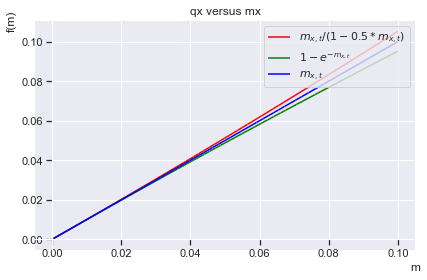

In [7]:
m=Symbol('m')
# teste:plot(expr, range, kwargs)
# teste:plot(x**2, line_color='red')
# teste:plot(sin(x),cos(x), (x, -pi, pi))
# m/(1-0.5*m)
# 1-exp(1)^m
# m
p = plot(m/(1-0.5*m), 1-exp(1)**(-m), m, (m, 0, 0.1), legend=True, title = 'qx versus mx', show=False) # Se retirar o show=False, o gráfico se repete
p[0].line_color = 'red'
p[1].line_color = 'green'
p[2].line_color = 'blue'
p[0].label = '$ {m_{x,t}}/{(1-0.5*m_{x,t})} $'
p[1].label = '$ 1-e^{-m_{x,t}} $'
p[2].label = '$ m_{x,t} $'
#plt.legend(loc='lower right')
p.save(pasta_resultados + '/' + 'qx_versus_mx.png')
p.show()
# plt.savefig('test.png')

##### 1.2 - Feature, denominada mx, Taxa Central de Mortalidade, para comparar se existe diferença substancial dos parâmetros zx, bx, kt, utilizados no modelo Lee-Carter
$ m_x = \frac{dx}{Lx} $

In [5]:
# Criar a feature mx = dx/Lx
df_dados['qx_prob'] = df_dados['qx_mil']/1000.0
df_dados['mx'] = df_dados['dx']/df_dados['Lx']
# df_dados['mx'] = np.where(df_dados['qx_prob']>=1.0, 1.0, df_dados['dx']/df_dados['Lx']) 

In [9]:
pd.DataFrame(df_dados).head().append(pd.DataFrame(df_dados).tail(10))

,idade,qx_mil,dx,lx,Lx,Tx,expx,ano,qx_prob,mx
0,0,33.240000,3.324000e+03,1.000000e+05,9.833800e+04,6.967679e+06,69.676788,1998,0.033240,0.033802
1,1,3.568621,3.450000e+02,9.667600e+04,9.650350e+04,6.869341e+06,71.055286,1998,0.003569,0.003575
2,2,1.910081,1.840000e+02,9.633100e+04,9.623900e+04,6.772837e+06,70.307973,1998,0.001910,0.001912
3,3,1.393699,1.340000e+02,9.614700e+04,9.608000e+04,6.676598e+06,69.441567,1998,0.001394,0.001395
4,4,1.031110,9.900000e+01,9.601300e+04,9.596350e+04,6.580518e+06,68.537784,1998,0.001031,0.001032
2447,107,976.278109,6.652730e+00,6.814380e+00,3.488015e+00,3.568949e+00,0.523738,2018,0.976278,1.907311
2448,108,999.326534,1.615411e-01,1.616500e-01,8.087942e-02,8.093386e-02,0.500673,2018,0.999327,1.997308
2449,109,999.999534,1.088657e-04,1.088658e-04,5.443291e-05,5.443294e-05,0.500000,2018,1.000000,1.999998
2450,110,1000.000000,5.078435e-11,5.078435e-11,2.539218e-11,2.539218e-11,0.500000,2018,1.000000,2.000000
2451,111,1000.000000,1.105879e-23,1.105879e-23,5.529396e-24,5.529396e-24,0.500000,2018,1.000000,2.000000


##### 1.3 - Visualização  $ l_x, q_x $ e $ log(m_x) $ dos anos 2000, 2010 e 2018 (amostra)

In [6]:
# Gráfico de m{x,t}. Amostral 
df_dados2018 = df_dados.query("ano == 2018")
df_dados2010 = df_dados.query("ano == 2010")
df_dados2000 = df_dados.query("ano == 2000")

No handles with labels found to put in legend.


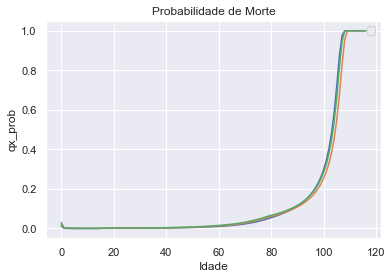

In [11]:
#df_dadosx_0['ano'] = df_dadosx_0['ano'].astype(str)
#graf_0 = sns.lineplot('x', 'lx', ci=None, data=df_dados2018)
fig, ax = plt.subplots()
ax.plot(df_dados2018['idade'], df_dados2018['qx_prob'])
ax.plot(df_dados2010['idade'], df_dados2010['qx_prob'])
ax.plot(df_dados2000['idade'], df_dados2000['qx_prob'])
#plt.plot('idade', 'lx', data=df_dados2018)
plt.title("Probabilidade de Morte")
plt.xlabel('Idade')
plt.ylabel('qx_prob')
plt.legend()
plt.show()

No handles with labels found to put in legend.


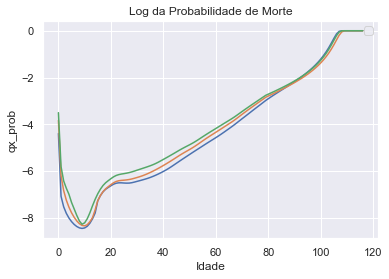

In [12]:
# Gráfico de log(mx{x,t})
fig, ax = plt.subplots()
ax.plot(df_dados2018['idade'], np.log(df_dados2018['qx_prob']))
ax.plot(df_dados2010['idade'], np.log(df_dados2010['qx_prob']))
ax.plot(df_dados2000['idade'], np.log(df_dados2000['qx_prob']))
#ax.plot('idade', np.log('mx'), data=df_dados2000)
#plt.plot('idade', 'lx', data=df_dados2018)
plt.title("Log da Probabilidade de Morte")
plt.xlabel('Idade')
plt.ylabel('qx_prob')
plt.legend()
plt.show()

In [7]:
# O maior range de idade. Já foi tratado na preparação de dados. Importante a série anual ter o mesmo tamanho
w_max = max(df_dados['idade'])
#w = df_dados.groupby('ano').max()
primeiro_ano = 1998 
ultimo_ano = 2018
print(w_max)

116


In [8]:
# Verificar a primeira coorte anual. Feature qx.
mx = df_dados[df_dados['ano'] == primeiro_ano].values[:,8].reshape(w_max+1, 1)
pd.DataFrame(mx)

,0
0,0.033240
1,0.003569
2,0.001910
3,0.001394
4,0.001031
...,...
112,1.000000
113,1.000000
114,1.000000
115,1.000000


In [9]:
#Reshape o arquivo horizontalmente.
# Observar que o primeiro valor do range, considrar ano+1, porque a primeira coorte foi atribuída anteriormente.
# Se for executar este bloco, executar a célula anterior
for i in np.arange(primeiro_ano+1,ultimo_ano+1):
    mx = np.hstack([mx, df_dados[df_dados['ano'] == i].values[:,8].reshape(w_max+1,1)])

# O eixo também é armazenado na lista
idade=[x for x in range(w_max+1)]
ano=[x for x in range(primeiro_ano,ultimo_ano+1,1)]

In [16]:
pd.DataFrame(mx)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.033240,0.031650,0.030070,0.029200,0.028370,0.027500,0.026580,0.025769,0.024891,0.024036,...,0.022467,0.021638,0.016139,0.015694,0.015023,0.014399,0.013824,0.013297,0.012808,0.012358
1,0.003569,0.003284,0.002990,0.002874,0.002758,0.002643,0.002567,0.002422,0.002292,0.002182,...,0.002152,0.002026,0.001047,0.000983,0.000937,0.000930,0.000902,0.000878,0.000848,0.000841
2,0.001910,0.001761,0.001624,0.001560,0.001496,0.001439,0.001382,0.001327,0.001255,0.001198,...,0.001132,0.001075,0.000665,0.000629,0.000610,0.000599,0.000578,0.000569,0.000548,0.000538
3,0.001394,0.001287,0.001191,0.001190,0.001100,0.001058,0.001039,0.000989,0.000922,0.000880,...,0.000750,0.000716,0.000501,0.000477,0.000467,0.000456,0.000439,0.000435,0.000418,0.000407
4,0.001031,0.000973,0.000920,0.000891,0.000845,0.000872,0.000754,0.000739,0.000699,0.000659,...,0.000552,0.000529,0.000408,0.000390,0.000385,0.000374,0.000360,0.000358,0.000344,0.000333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
113,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
114,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
115,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
# log(mx)É uma matriz de idade x ano de observação
logmx=np.log(mx)
pd.DataFrame(logmx)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-3.404001,-3.453017,-3.504227,-3.533587,-3.562423,-3.593575,-3.627600,-3.658573,-3.693268,-3.728210,...,-3.795695,-3.833288,-4.126493,-4.154451,-4.198176,-4.240562,-4.281337,-4.320209,-4.357692,-4.393431
1,-5.635576,-5.718712,-5.812513,-5.852079,-5.893158,-5.935869,-5.965024,-6.022987,-6.078309,-6.127304,...,-6.141507,-6.201731,-6.862134,-6.924886,-6.972787,-6.980207,-7.011393,-7.038021,-7.072213,-7.080603
2,-6.260610,-6.341676,-6.423154,-6.463133,-6.504649,-6.543579,-6.584525,-6.624581,-6.680656,-6.727050,...,-6.783402,-6.835467,-7.315617,-7.371256,-7.402585,-7.420357,-7.455233,-7.472037,-7.508700,-7.528418
3,-6.575794,-6.655430,-6.732843,-6.733919,-6.812313,-6.850925,-6.869693,-6.918717,-6.989254,-7.035370,...,-7.195380,-7.241491,-7.598190,-7.648778,-7.669314,-7.693660,-7.730833,-7.741256,-7.779296,-7.806366
4,-6.877119,-6.935032,-6.991289,-7.023314,-7.076510,-7.044881,-7.189702,-7.209567,-7.265291,-7.325328,...,-7.502540,-7.543810,-7.803734,-7.850285,-7.862723,-7.891883,-7.930584,-7.936297,-7.975221,-8.007733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
113,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
114,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
115,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### Passo 2: Modelo Lee-Carter
##### Lee,  R.D.,  Carter,  L.R.  (1992).  Modelling  and  Forecasting  U.S.  Mortality.  Journal of the American Statistical Association 87, 659-671

2.1 - Formula: $ ln(m_{x,t}) = a_x + b_x*k_t + \epsilon_{x,t} \\ $ 
2.1.1 - Restrições:
$ \Sigma b_x=1\\
\Sigma k_x=0 $

Onde:
* $ m_{x,t} $: Corresponde a Taxa central de mortalidade para cada idade *x*; 
* $ a_x $: Nível médio das taxas de mortalidade no tempo para cada idade *x*; 
* $ b_x $: Padrão médio da mortalidade à idade *x* quando o nível geral da mortalidade $ k_t $ se altera; 
* $ k_t $: Índice de tendência temporal do nível de mortalidade geral; 
* $ \epsilon_{x,t} $: Erro aleatório do tipo ruído branco, inserido no modelo para cada idade *x* no tempo *t*.

2.2 - Estimadores

2.2.1 - Fórmula 1:
$ \hat\alpha_x = \frac{1}{h} \sum\limits_{t=t_1} ^{t_n} ln (m_{x,t}) \\ $
Sendo: $ h = t_n - t_1 $

2.2.2 - Fórmula 2:
$ \beta_x*k_t = ln(m_{x,t}) - \alpha_x + \epsilon_{x,t} $

##### A Fórmula 2, na forma matricial Z, onde será aplicada a SVD (Singular Value Decomposition).
$ Z = \begin{vmatrix}
ln(m_{0,1998})-\hat\alpha_0 & ln(m_{0,1999})-\hat\alpha_0 & ... & ln(m_{0,2018})-\hat\alpha_0\\
ln(m_{1,1998})-\hat\alpha_1 & ln(m_{1,1999})-\hat\alpha_1 & ... & ln(m_{1,2018})-\hat\alpha_1\\
. & . & .\\
. & . & .\\
ln(m_{116,1998})-\hat\alpha_{116} & ln(m_{116,1999})-\hat\alpha_{116} & ... & ln(m_{116,2018})-\hat\alpha_{116}\\
\end{vmatrix} $

#### 2.3 - Singular Value Decomposition - SVD

* Estima o valor de b(x) e k(t) com o uso do método Singular Value Decomposition (SVD).
* Este método permite a decomposição da matriz [z_xt] de m linhas por n colunas em 3 matrizes:
* a matrix U de m por m, a matriz V de n por n e a matriz diagonal S de m por n.
$ A = USV^T $

##### 2.3.1 - A fórmula 2, reescrita com base na matriz Z:
##### 2.3.2 - Fórmula 3:
$ \hat\beta_x = \frac {U_{x,1}}{\sum\limits_{x=x_0} ^{x_{\omega}} U_{x,1}} $
##### 2.3.3 - Fórmula 4: Estima a feature tempo. Baseado no modelo ARIMA. 
$ \hat\kappa_t = V_{t,1}S_{1,1}\sum\limits_{x=x_0} ^{x_{\omega}} U_{x,1} $

##### 2.3.4 - Parametros iniciais da Matriz

In [11]:
#Parametros iniciais da Matriz
T = (ultimo_ano - primeiro_ano) +1  # Intervalo de anos disponíveis no dataset (1998-2018)
N = w_max + 1 # Idade Máxima em cada ano
logm_xt = logmx + 0 

# Estimativa dos parâmetros:
a_x = logm_xt.sum(axis=1) / T # (FÓRMULA 1)
# Para obter os parÂmetros estimados de ^bx e ^kt, aplica-se a SVD na matriz Z = ln(m{x,t}) - ^ax
z_xt = logm_xt - a_x.reshape(N,1) # (FÓRMULA 2)

In [19]:
pd.DataFrame(a_x).head(2).append(pd.DataFrame(a_x).tail(7))

,0
0,-3.867587e+00
1,-6.352652e+00
110,-7.105147e-07
111,-4.633452e-12
112,0.000000e+00
113,0.000000e+00
114,0.000000e+00
115,0.000000e+00
116,0.000000e+00


In [12]:
# pd.set_option("display.precision", 5)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [21]:
pd.DataFrame(z_xt).head(3).append(pd.DataFrame(z_xt).tail())

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.46359,0.41457,0.36336,0.33400,0.30516,0.27401,0.23999,0.20901,0.17432,0.13938,...,0.07189,0.03430,-0.25891,-0.28686,-0.33059,-0.37298,-0.41375,-0.45262,-0.49010,-0.52584
1,0.71708,0.63394,0.54014,0.50057,0.45949,0.41678,0.38763,0.32967,0.27434,0.22535,...,0.21114,0.15092,-0.50948,-0.57223,-0.62014,-0.62756,-0.65874,-0.68537,-0.71956,-0.72795
2,0.64331,0.56224,0.48076,0.44078,0.39927,0.36034,0.31939,0.27934,0.22326,0.17687,...,0.12052,0.06845,-0.41170,-0.46734,-0.49867,-0.51644,-0.55132,-0.56812,-0.60478,-0.62450
112,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
113,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
114,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
115,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
116,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [13]:
pd.reset_option('display.float_format')

In [12]:
# O modelo Lee-Carter é simples por utilizar a estimativa dos parâmetros pelo SVD
U, S, V = np.linalg.svd(z_xt, full_matrices=True)

bxkt = S[0] * np.dot(U[:,0].reshape(N,1),V[0,:].reshape(T,1).T) #
eps = z_xt - bxkt

# Modelo Lee-Carter
logm_xt_lcfitted = bxkt + a_x.reshape(N,1)

#bx,kx:
# Para estimar os parâmetros b(x) and k(t) , O Modelo Lee-Carter usa k=rank(Z).
# A estimativa do valor de b(x) pode ser obtido como o resultado da primeira coluna da matriz U
b_x = U[:,0]/U[:,0].sum() # (FÓRMULA 3)
# Para a estimativa do valor de k(t) é o resultado da multiplicação do primeiro valor singular e a primeira coluna da matriz V.
k_t = V[0,:]*S[0]*U[:,0].sum() # (FÓRMULA 4)

# Para estimar os valores a(x) e k(t):
a_x = a_x + k_t.sum()*b_x
k_t = k_t - k_t.sum()

In [33]:
# Formula 2.1.1
# A restrição foi observada somatório b_x -> 1
# A restrição foi observada somatório k_t -> 0

print('bx:', pd.DataFrame(b_x)[0].sum())
print()
print('kt:', np.around(pd.DataFrame(k_t)[0].sum(), decimals=10))

bx: 1.0

kt: 0.0


Optei por não agrupar as idades, usarei o qx_prob.

##### 2.3.5 - Gráfico das componentes do modelo: ax, bx e kt

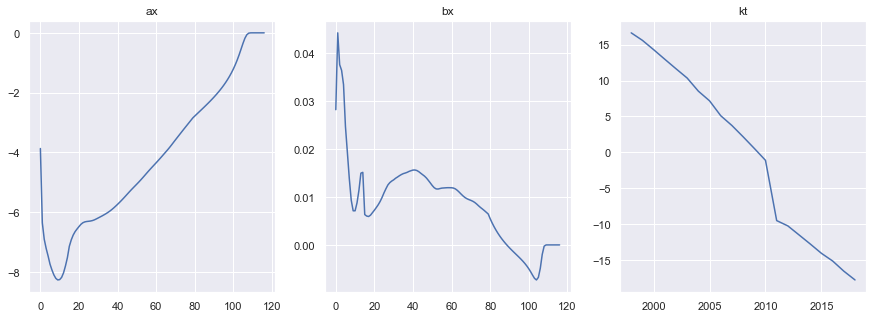

In [24]:
# Gráfico de ax,bx,kt.  
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(idade, a_x)
ax[0].set_title('ax')
ax[1].plot(idade, b_x)
ax[1].set_title('bx')
ax[2].plot(ano, k_t)
ax[2].set_title('kt')
plt.show()

##### 2.3.6 - Verificar convergencia do modelo 

In [13]:
#ax+bx*kt Confirmar se o valor previsto é convergente
chk = logm_xt_lcfitted - a_x.reshape(N,1)
chk = chk - np.dot(b_x.reshape(N,1),k_t.reshape(T,1).T)
chk = chk*chk
print(chk.sum())

2.4016000107494774e-28


##### Como a somatória dos valores tende a zero, o valor é convergente. Em resumo: $ a_x, b_x $ são estimadores para a feature idade e $ k_t $ é o estimador para a feature tempo. 

In [26]:
print(pd.DataFrame(a_x).shape)
print(pd.DataFrame(b_x).shape)
print(pd.DataFrame(k_t).shape)
print(pd.DataFrame(logm_xt_lcfitted).shape)

(117, 1)
(117, 1)
(21, 1)
(117, 21)


In [27]:
df_dados2018.head()

,idade,qx_mil,dx,lx,Lx,Tx,expx,ano,qx_prob,mx
2340,0,12.358261,1235.826059,100000.000000,99382.086970,7.631032e+06,76.310316,2018,0.012358,0.012435
2341,1,0.841266,83.086936,98764.173941,98722.630472,7.531649e+06,76.258923,2018,0.000841,0.000842
2342,2,0.537588,53.049798,98681.087004,98654.562105,7.432927e+06,75.322710,2018,0.000538,0.000538
2343,3,0.407135,40.154922,98628.037206,98607.959745,7.334272e+06,74.362955,2018,0.000407,0.000407
2344,4,0.332879,32.817788,98587.882284,98571.473390,7.235664e+06,73.393040,2018,0.000333,0.000333


#### Passo 3: Projeção da Mortalidade do Modelo Lee-Carter. Uso do modelo ARIMA

##### 3.1 - Preparar Dataset

In [14]:
# Preparar dataset
serie = {'t': ano, 'k_t': k_t}
df_tendencia = pd.DataFrame(serie, columns=['t','k_t'])
df_tendencia['t'] = pd.to_datetime(df_tendencia['t'], format='%Y')
df_tendencia.set_index('t', inplace=True)

In [29]:
df_tendencia.head() 

,k_t
t,
1998-01-01,16.645931
1999-01-01,15.603346
2000-01-01,14.307902
2001-01-01,12.967653
2002-01-01,11.645519


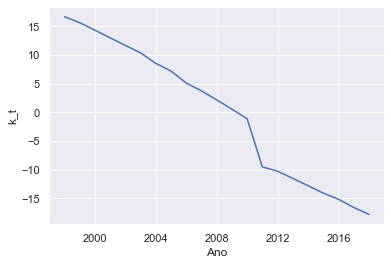

In [30]:
plt.xlabel('Ano')
plt.ylabel('k_t')
plt.plot(df_tendencia)


* 3.1.1 - Verificar se a série é estacionaria, antes de construir o modelo. Se for estacionaria, d=0
* 3.1.2 - Uma série é estacionária quando a média NÃO é função do tempo (não incrementa com o tempo)
* 3.1.3 - Uma série é estacionária quando a variancia NÃO é função do tempo. Esta propriedade é conhecida como homocedastidade.
* 3.1.4 -  Uma série é estacionária quando a covariancia NÃO é função do tempo
* 3.1.5 -  A stationary time series data is one whose properties do not depend on the time, That is why time series with trends, or with seasonality, are not stationary. 



#### 3.2 - Data Decomposition
* Decompor a feature alvo do dataset para verificar ou auxiliar na remoção da sazonalidade.
* A Decomposição tem 3 componentes, conforme o gráfico abaixo: Tendencia, sazonalidade e ruídos.
* O modelo aditivo foi escolhido porque a sazonalidade não varia ao longo do tempo. O outro modelo é o multiplicativo.

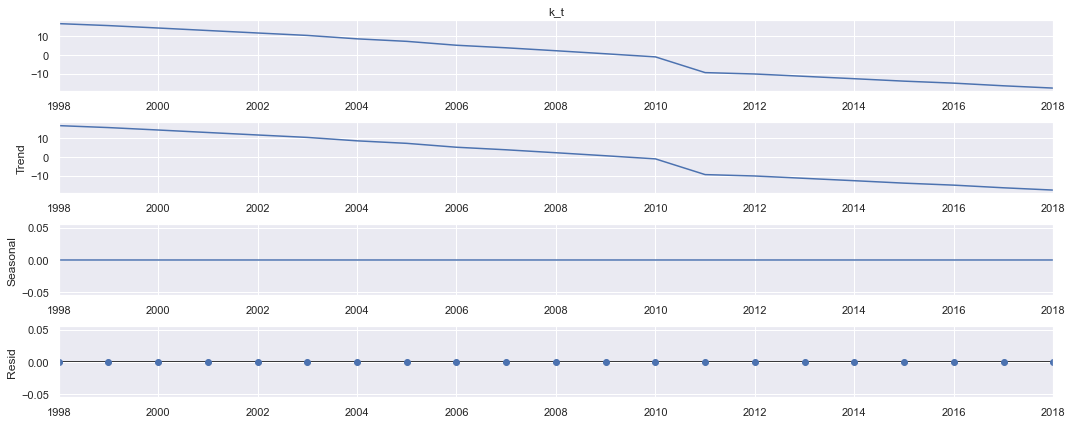

In [32]:
decomposition = sm.tsa.seasonal_decompose(df_tendencia.k_t, model='additive')
plt.rcParams["figure.figsize"] = [15,6]
fig = decomposition.plot()

* Graficamente, vemos que a série não tem sazonalidade ou ruído branco

#### 3.3 - Verificar a Estacionariedade

In [33]:
# First, I am going to check if the series is stationary using the Augmented Dickey Fuller test.
# You need differencing only if the series is non-stationary. Else, no differencing is needed, that is, d=0.
# if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed(de fato) stationary, ou seja, nossa série é estacionária: d<>0.
# Augmented Dickey-Fuller Test: The time series is considered stationary if the p-value # is low (according to the null hypothesis) and the critical values at 1%, 5%, 10% #confidence intervals are as close as possible to the ADF Statistics
#The ADF Statistic is far from the critical values and the p-value is greater than the threshold (0.05)
result = adfuller(k_t)
#print('ADF Statistic: %f' % result[0])
#print('p-value: %f' % result[1])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))
if result[1] < 0.05:
    print('A série é estacionária. p-value é ',  result[1])
else:
    print('A série não é estacionária, pois p-value é maior que 0.05 e ADF Statistic não é próximo dos Critical Values')

ADF Statistic: -0.04405181079070166
p-value: 0.9547338409354238
Critical Values:
	1%: -3.8092091249999998
	5%: -3.0216450000000004
	10%: -2.6507125
A série não é estacionária, pois p-value é maior que 0.05 e ADF Statistic não é próximo dos Critical Values


#### Passo 4 — Seleção dos parâmetros para o modelo de Série Temporal ARIMA (Métrica: MSE)

In [15]:
# Instrução para gerar um grid do melhor ARIMA

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])

    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error


In [16]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order, mse))

                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [17]:
# Parâmetros p, d e q do ARIMA
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)

In [37]:
warnings.filterwarnings("ignore")
evaluate_models(df_tendencia.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=318.820
ARIMA(0, 0, 1) MSE=85.553
ARIMA(0, 0, 2) MSE=54.788
ARIMA(0, 1, 0) MSE=0.524
ARIMA(0, 1, 1) MSE=7.795
ARIMA(0, 1, 2) MSE=1.431
ARIMA(0, 2, 0) MSE=9.841
ARIMA(0, 2, 1) MSE=2.903
ARIMA(1, 0, 0) MSE=2.120
ARIMA(1, 1, 0) MSE=1.129
ARIMA(1, 2, 0) MSE=12.497
ARIMA(2, 1, 0) MSE=1.263
ARIMA(2, 2, 0) MSE=19.197
Best ARIMA(0, 1, 0) MSE=0.524


* Calcular outras medidas para o melhor arima AIC (Akaike Information Criterion) e BIC (Bayesian Information Criterion)


#### Passo 4 — Seleção dos parâmetros para o modelo de Série Temporal ARIMA (Métrica: AIC)

In [38]:
arima_model = pm.auto_arima(df_tendencia, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=20,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      approx=False,
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=False)

print(arima_model.summary())

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=78.451, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=80.230, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=82.181, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=83.500, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=80.249, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=80.515, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=84.168, Time=0.46 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=86.145, Time=0.47 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=82.216, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=82.482, Time=0.51 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=84.536, Time=0.60 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=88.180, Time=0.46 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=84.146, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=84.256, Time=0.53 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=88.177, Time=0.30 sec
Total fit time: 4.489 seconds
          

#### Passo 5 — Fitting a Série ARIMA

In [18]:
# fit model
model = ARIMA(df_tendencia, order=(0,1,0))
model_fit = model.fit(disp=0) # disp=0 (para desabilitar avisos)
print(model_fit.summary())  # print(model_fit.summary().tables[1]) 

                             ARIMA Model Results                              
Dep. Variable:                  D.k_t   No. Observations:                   20
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -37.226
Method:                           css   S.D. of innovations              1.556
Date:                Thu, 19 Nov 2020   AIC                             78.451
Time:                        09:16:13   BIC                             80.443
Sample:                    01-01-1999   HQIC                            78.840
                         - 01-01-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7216      0.348     -4.947      0.000      -2.404      -1.040
/home/doug/anaconda3/envs/deeplearning/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequenc

#### Passo 6 — Previsão do Modelo

In [19]:
n=20
previsao,err,ci = model_fit.forecast(steps=n,alpha=0.05)

df_previsao = pd.DataFrame({'previsao':previsao},index=pd.date_range(start='1/1/2019',periods=n, freq='AS')) # Annual Start: AS (INICIA COM 01-01-YYYY). Somente A, o final 31-12-YYYY

In [45]:
ci

array([[-22.5586791 , -16.4578663 ],
       [-25.54382753, -16.91597533],
       [-28.23498903, -17.66807129],
       [-30.77397169, -18.57234609],
       [-33.21570369, -19.57387155],
       [-35.58835554, -20.64447716],
       [-37.90866182, -21.76742835],
       [-40.18752602, -22.93182161],
       [-42.43252175, -24.13008334],
       [-44.64916329, -25.35669926],
       [-46.84161349, -26.60750651],
       [-49.01310647, -27.87927099],
       [-51.16621415, -29.16942077],
       [-53.30302184, -30.47587055],
       [-55.42524812, -31.79690173],
       [-57.53432926, -33.13107805],
       [-59.63148018, -34.47718459],
       [-61.71773943, -35.83418281],
       [-63.79400309, -37.20117661],
       [-65.86105072, -38.57738643]])

In [46]:
df_previsao.head(10)

,previsao
2019-01-01,-19.508273
2020-01-01,-21.229901
2021-01-01,-22.951530
2022-01-01,-24.673159
2023-01-01,-26.394788
2024-01-01,-28.116416
2025-01-01,-29.838045
2026-01-01,-31.559674
2027-01-01,-33.281303
2028-01-01,-35.002931


#### 6.1 - Previsão com Intervalo de Confiança de 95%

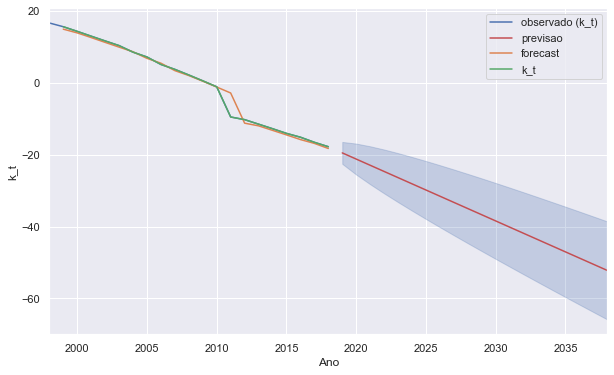

In [60]:
ax = df_tendencia[0:].k_t.plot(label='observado (k_t)', figsize=(10, 6))
df_previsao.plot(ax=ax, color='r')
model_fit.plot_predict(ax=ax, dynamic=False)
ax.fill_between(df_previsao.index,
                ci[:,0],
                ci[:,1],               
                color='b', alpha=.25)
ax.set_xlabel('Ano')
ax.set_ylabel('k_t')
#plt.legend()
plt.show()

In [ ]:
Tentar juntar o grafico abaixo com o de cima

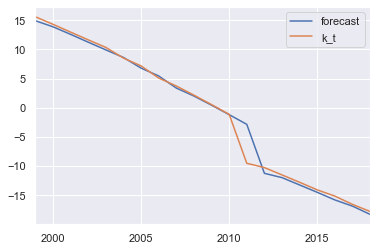

In [19]:
# Actual vs Fitted
# When you set dynamic=False the in-sample lagged values are used for prediction.
model_fit.plot_predict(dynamic=False)
plt.show()

#### Passo 7: Construir a tábua de qx a partir dos valores de $ k_t $ previstos.

In [24]:
df_previsao.head()

,previsao
2019-01-01,-19.508273
2020-01-01,-21.229901
2021-01-01,-22.951530
2022-01-01,-24.673159
2023-01-01,-26.394788


In [20]:
#df_LeeCarter = pd.concat([df_tendencia, df_previsao])

In [21]:
# df_LeeCarter.fillna(0, inplace=True)
#df_LeeCarter['kt'] = (df_LeeCarter['k_t'] + df_LeeCarter['previsao'])
#df_LeeCarter.drop(['previsao','k_t'], axis=1, inplace=True)

In [34]:
df_previsao.head().append(df_previsao.tail())

,previsao
2019-01-01,-19.508273
2020-01-01,-21.229901
2021-01-01,-22.951530
2022-01-01,-24.673159
2023-01-01,-26.394788
2034-01-01,-45.332704
2035-01-01,-47.054332
2036-01-01,-48.775961
2037-01-01,-50.497590
2038-01-01,-52.219219


In [35]:
print(pd.DataFrame(a_x).shape)
print(pd.DataFrame(b_x).shape)
print(df_previsao.shape)

(117, 1)
(117, 1)
(20, 1)


In [36]:
kt = df_previsao['previsao'].values

In [37]:
kt

array([-19.5082727 , -21.22990143, -22.95153016, -24.67315889,
       -26.39478762, -28.11641635, -29.83804508, -31.55967381,
       -33.28130254, -35.00293127, -36.72456   , -38.44618873,
       -40.16781746, -41.88944619, -43.61107492, -45.33270366,
       -47.05433239, -48.77596112, -50.49758985, -52.21921858])

In [38]:
len(kt)

20

In [39]:
pd.DataFrame(kt.reshape(len(kt),1).T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-19.508273,-21.229901,-22.95153,-24.673159,-26.394788,-28.116416,-29.838045,-31.559674,-33.281303,-35.002931,-36.72456,-38.446189,-40.167817,-41.889446,-43.611075,-45.332704,-47.054332,-48.775961,-50.49759,-52.219219


In [40]:
np.exp(a_x.reshape(len(a_x), 1) + b_x.reshape(len(b_x), 1)*kt.reshape(len(kt), 1).T)

array([[1.20614066e-02, 1.14897891e-02, 1.09452618e-02, ...,
        5.28369385e-03, 5.03328758e-03, 4.79474864e-03],
       [7.35143085e-04, 6.81245380e-04, 6.31299236e-04, ...,
        2.01470132e-04, 1.86699160e-04, 1.73011136e-04],
       [4.82122853e-04, 4.51906832e-04, 4.23584535e-04, ...,
        1.60438256e-04, 1.50383131e-04, 1.40958189e-04],
       ...,
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

In [51]:
# anos do intervalo da previsão
ano_inicio = df_previsao.index.year[0]
anos = np.arange(ano_inicio, ano_inicio+len(kt))
anos


array([2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029,
       2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038])

In [52]:
df_qxleecarter = pd.DataFrame(np.exp(a_x.reshape(len(a_x), 1) + b_x.reshape(len(b_x), 1)*kt.reshape(len(kt), 1).T), columns=anos)

<AxesSubplot:>

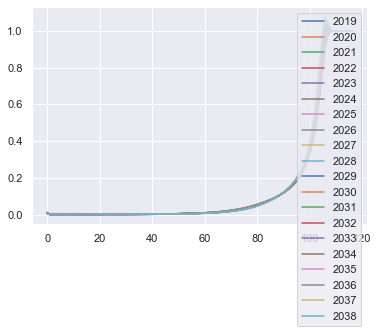

In [54]:
# ln(qx) = a_x + b_x *k_t
pd.DataFrame(df_qxleecarter).plot()

In [53]:
df_qxleecarter.head()

,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038
0,0.012061,0.011490,0.010945,0.010427,0.009932,0.009462,0.009013,0.008586,0.008179,0.007792,0.007422,0.007071,0.006735,0.006416,0.006112,0.005822,0.005547,0.005284,0.005033,0.004795
1,0.000735,0.000681,0.000631,0.000585,0.000542,0.000502,0.000466,0.000431,0.000400,0.000370,0.000343,0.000318,0.000295,0.000273,0.000253,0.000235,0.000217,0.000201,0.000187,0.000173
2,0.000482,0.000452,0.000424,0.000397,0.000372,0.000349,0.000327,0.000306,0.000287,0.000269,0.000252,0.000237,0.000222,0.000208,0.000195,0.000183,0.000171,0.000160,0.000150,0.000141
3,0.000363,0.000341,0.000320,0.000301,0.000282,0.000265,0.000249,0.000234,0.000220,0.000206,0.000194,0.000182,0.000171,0.000161,0.000151,0.000142,0.000133,0.000125,0.000117,0.000110
4,0.000299,0.000282,0.000266,0.000252,0.000237,0.000224,0.000212,0.000200,0.000189,0.000178,0.000168,0.000159,0.000150,0.000141,0.000133,0.000126,0.000119,0.000112,0.000106,0.000100


#### Passo 8: Exportar os resultados

In [57]:
df_previsao.to_csv(pasta_resultados + '/' + 'kt_previsao.csv')

In [58]:
df_qxleecarter.to_csv(pasta_resultados + '/' + 'leecarter_previsao.csv')

In [ ]:
# APROVEITAR ESTES TEXTOS NO ARTIGO

In [ ]:
# ARIMA
* auto-regressive integrated moving average and is specified by these three order parameters: (p, d, q)
* An auto regressive (AR(p)) component is referring to the use of past values in the regression equation for the series Y.
* A moving average (MA(q)) component represents the error of the model as a combination of previous error terms et.
p is the order of the AR term
q is the order of the MA term
d is the number of differencing required to make the time series stationary
p é o número de termos autorregressivos;
d é o número de vezes que a série é difetenciada para se tornar estacionária;
q é o número de termos da média móvel;

In [32]:
pd.DataFrame(b_x).head().append(pd.DataFrame(b_x).tail(10))

,0
0,2.820125e-02
1,4.422707e-02
2,3.759401e-02
3,3.641658e-02
4,3.345041e-02
107,-1.983655e-03
108,-2.502482e-04
109,-3.503658e-06
110,5.169433e-10
111,2.748140e-14


In [33]:
pd.DataFrame(k_t).head(21) #.append(pd.DataFrame(k_t).tail(15))

,0
0,16.645931
1,15.603346
2,14.307902
3,12.967653
4,11.645519
5,10.348801
6,8.522160
7,7.175413
8,5.099266
9,3.733430


In [34]:
pd.DataFrame(eps).head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-0.005851,-0.025464,-0.040141,-0.031704,-0.023254,-0.017837,-0.000348,0.006659,0.030513,0.034089,...,0.056586,0.065913,0.009473,0.002388,-0.005879,-0.012660,-0.016728,-0.025525,-0.023022,-0.024238
1,-0.019125,-0.056151,-0.092658,-0.072948,-0.055554,-0.040915,0.010717,0.012318,0.048818,0.060229,...,0.187140,0.200501,-0.088592,-0.118610,-0.110903,-0.062485,-0.036104,-0.015567,0.012950,0.058700
2,0.017520,-0.024351,-0.057128,-0.046721,-0.038534,-0.028714,-0.000990,0.009584,0.031559,0.036513,...,0.100112,0.110595,-0.053934,-0.081748,-0.065809,-0.036117,-0.022060,0.001227,0.017868,0.044171
3,0.029310,-0.012358,-0.042596,0.005135,-0.025111,-0.016501,0.031251,0.031271,0.036340,0.039963,...,-0.003853,0.010625,-0.040337,-0.063971,-0.038720,-0.017089,-0.006862,0.021551,0.035145,0.052655
4,0.028774,0.005736,-0.007188,0.005620,-0.003351,0.071654,-0.012065,0.013119,0.026843,0.012494,...,-0.057989,-0.043604,-0.022694,-0.044488,-0.014867,-0.001795,0.003043,0.033003,0.041508,0.049944


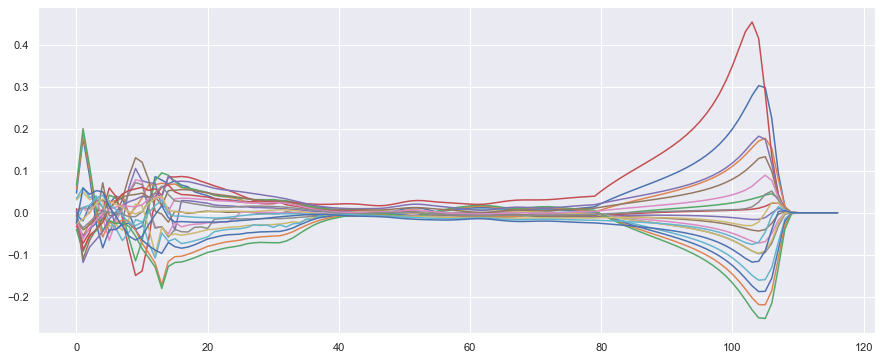

In [96]:

plt.plot(pd.DataFrame(eps))

In [35]:
pd.DataFrame(bxkt).head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.469436,0.440034,0.403501,0.365704,0.328418,0.291849,0.240336,0.202356,0.143806,0.105287,...,0.015306,-0.031614,-0.268379,-0.289252,-0.324711,-0.360315,-0.397022,-0.427097,-0.467083,-0.501606
1,0.736201,0.690090,0.632797,0.573521,0.515047,0.457697,0.376910,0.317347,0.225526,0.165119,...,0.024004,-0.049580,-0.420890,-0.453624,-0.509233,-0.565070,-0.622637,-0.669802,-0.732511,-0.786651
2,0.625787,0.586592,0.537891,0.487506,0.437802,0.389053,0.320382,0.269753,0.191702,0.140355,...,0.020404,-0.042144,-0.357766,-0.385591,-0.432859,-0.480323,-0.529255,-0.569347,-0.622651,-0.668671
3,0.606188,0.568220,0.521045,0.472238,0.424090,0.376868,0.310348,0.261304,0.185698,0.135959,...,0.019765,-0.040824,-0.346561,-0.373514,-0.419302,-0.465279,-0.512679,-0.551515,-0.603150,-0.647729
4,0.556813,0.521938,0.478605,0.433773,0.389547,0.346172,0.285070,0.240020,0.170573,0.124885,...,0.018155,-0.037499,-0.318333,-0.343091,-0.385150,-0.427382,-0.470921,-0.506593,-0.554022,-0.594970


In [36]:
pd.DataFrame(logm_xt_lcfitted)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-3.398151,-3.427553,-3.464086,-3.501883,-3.539169,-3.575738,-3.627251,-3.665231,-3.723781,-3.762299,...,-3.852281,-3.899201,-4.135966,-4.156839,-4.192297,-4.227902,-4.264609,-4.294684,-4.334670,-4.369192
1,-5.616451,-5.662562,-5.719855,-5.779130,-5.837605,-5.894955,-5.975742,-6.035304,-6.127126,-6.187533,...,-6.328648,-6.402232,-6.773542,-6.806276,-6.861884,-6.917722,-6.975288,-7.022453,-7.085163,-7.139303
2,-6.278130,-6.317325,-6.366026,-6.416411,-6.466116,-6.514864,-6.583535,-6.634165,-6.712216,-6.763563,...,-6.883513,-6.946061,-7.261683,-7.289508,-7.336777,-7.384240,-7.433173,-7.473264,-7.526568,-7.572589
3,-6.605104,-6.643071,-6.690247,-6.739054,-6.787202,-6.834424,-6.900944,-6.949988,-7.025594,-7.075333,...,-7.191527,-7.252116,-7.557853,-7.584806,-7.630594,-7.676571,-7.723971,-7.762807,-7.814442,-7.859021
4,-6.905893,-6.940768,-6.984101,-7.028933,-7.073159,-7.116535,-7.177637,-7.222686,-7.292134,-7.337822,...,-7.444551,-7.500205,-7.781040,-7.805798,-7.847856,-7.890088,-7.933627,-7.969300,-8.016729,-8.057677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
113,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
114,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
115,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [37]:
pd.DataFrame(z_xt)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.463585,0.414570,0.363360,0.334000,0.305164,0.274012,0.239987,0.209014,0.174319,0.139376,...,0.071892,0.034299,-0.258906,-0.286864,-0.330589,-0.372976,-0.413750,-0.452622,-0.490105,-0.525844
1,0.717076,0.633939,0.540139,0.500573,0.459493,0.416782,0.387628,0.329665,0.274343,0.225348,...,0.211144,0.150921,-0.509482,-0.572234,-0.620136,-0.627555,-0.658741,-0.685369,-0.719561,-0.727951
2,0.643308,0.562241,0.480763,0.440785,0.399268,0.360339,0.319392,0.279337,0.223261,0.176867,...,0.120516,0.068451,-0.411700,-0.467339,-0.498668,-0.516440,-0.551316,-0.568120,-0.604783,-0.624500
3,0.635498,0.555862,0.478449,0.477373,0.398979,0.360367,0.341599,0.292575,0.222038,0.175922,...,0.015912,-0.030199,-0.386898,-0.437486,-0.458022,-0.482368,-0.519541,-0.529964,-0.568004,-0.595074
4,0.585587,0.527675,0.471417,0.439393,0.386197,0.417825,0.273004,0.253140,0.197415,0.137378,...,-0.039833,-0.081103,-0.341027,-0.387579,-0.400017,-0.429176,-0.467878,-0.473591,-0.512514,-0.545026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
113,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
114,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
115,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [31]:
pd.DataFrame(V[0,:].reshape(T,1).T)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-0.31367,-0.294024,-0.269613,-0.244358,-0.219444,-0.195009,-0.160588,-0.135211,-0.096089,-0.070351,...,-0.010227,0.021124,0.179327,0.193274,0.216966,0.240757,0.265284,0.285379,0.312098,0.335165


##### ==================================================================

##### Se houvesse diferença substancial dos gráficos, recriaria o qx com base na fórmula:
$$ q_x = \frac{2*m_x}{2+m_x} $$

#### TESTES

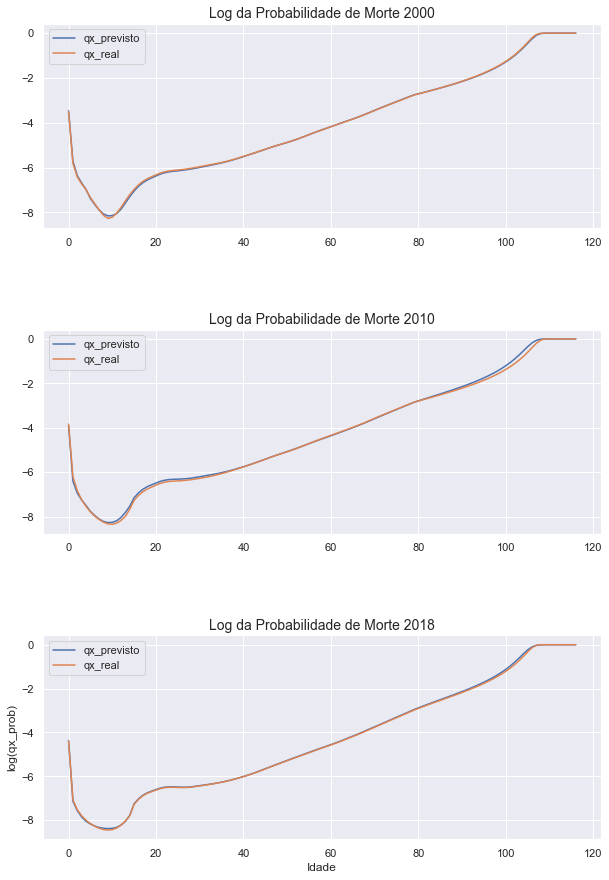

In [28]:
# Gráfico de m{x,t}. Amostral 
m_x2018 = logm_xt_lcfitted[:,20]
m_x2010 = logm_xt_lcfitted[:,12]
m_x2000 = logm_xt_lcfitted[:,2]

# Gerar graficos comparativo entre o real e estimado:
# real: qx. Estimado: resultado de a_x = a_x + k_t.sum()*b_x

fig, ax = plt.subplots(3,1,figsize=(10,15))

ax[0].plot(idade, m_x2000, label='qx_previsto')
ax[0].plot(idade, np.log(df_dados2000['qx_prob']), label='qx_real')
ax[0].set_title('Log da Probabilidade de Morte 2000', size=14)
ax[0].legend()
ax[1].plot(idade, m_x2010, label='qx_previsto')
ax[1].plot(idade, np.log(df_dados2010['qx_prob']), label='qx_real')
ax[1].set_title('Log da Probabilidade de Morte 2010', size=14)
ax[1].legend()
ax[2].plot(idade, m_x2018, label='qx_previsto')
ax[2].plot(idade, np.log(df_dados2018['qx_prob']), label='qx_real')
ax[2].set_title('Log da Probabilidade de Morte 2018', size=14)
ax[2].legend()
#ax[2].set_ylim(0,25) # para colocar o eixo y na mesma escala

plt.xlabel('Idade')
plt.ylabel('log(qx_prob)')
plt.subplots_adjust(hspace=0.5)
plt.show()


In [37]:
pd.DataFrame(a_x)

,0
0,-3.867587
1,-6.352652
2,-6.903917
3,-7.211292
4,-7.462706
...,...
112,0.000000
113,0.000000
114,0.000000
115,0.000000


In [38]:
pd.DataFrame(a_x.reshape(N,1).T)

,0,1,2,3,4,5,6,7,8,9,...,107,108,109,110,111,112,113,114,115,116
0,-3.867587,-6.352652,-6.903917,-7.211292,-7.462706,-7.737582,-7.931224,-8.09488,-8.209947,-8.26257,...,-0.062607,-0.010133,-0.000361,-7.105147e-07,-4.633452e-12,0.0,0.0,0.0,0.0,0.0
